In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install mne

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
import os
import zipfile
import mne
import seaborn as sns
from mne.datasets.sleep_physionet.age import fetch_data

from tensorflow.keras.layers import Input, Dense, Multiply, Activation, Lambda, Reshape, BatchNormalization, LeakyReLU, Flatten, Dropout, Conv1D, MaxPooling1D, AveragePooling1D, concatenate, Add, GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import backend as K
# from tensorflow.keras import metrics
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import Sequence, plot_model

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

from itertools import combinations

In [ ]:
def build_dataset(no_of_people=30):
  dataset = {'x': [], 'y':[]}
  people = [i for i in range(no_of_people)]
  remove_people = [36, 39, 52, 68, 69, 78, 79]
  for j in remove_people:
    try:
      people.remove(j)
    except ValueError:
      pass

  sf = 100
  annotation_desc_2_event_id = {'Sleep stage W': 1}
  event_id = {'Sleep stage W': 1}
  
  tmax = 30. - 1. / sf
  
  files = fetch_data(subjects=people, recording=[1])
  
  count = -1
        
  for file in files:
    temp_X = []
    temp_Y = []  
    raw = mne.io.read_raw_edf(file[0])
    annot = mne.read_annotations(file[1])
    raw.set_annotations(annot, emit_warning=False)
    events, _ = mne.events_from_annotations(
        raw, event_id=annotation_desc_2_event_id, chunk_duration=30.)
    epochs = mne.Epochs(raw=raw, events=events,
                              event_id=event_id, tmin=0., tmax=tmax, baseline=None)
    print("Subject No: ", count)
    count += 1
    if count == 0:
      x = (epochs.get_data(picks="eeg"))[:,0,:]
      y = epochs.events[:, 2]
      for i in range(y.shape[0]):
        if y[i] == 1:
          temp_Y.append(count)
          temp_X.append(x[i,:])
      X = np.array(temp_X)
      Y = np.array(temp_Y)
      
    else:
      x = (epochs.get_data(picks="eeg"))[:,0,:]
      y = epochs.events[:, 2]
      for i in range(y.shape[0]):
        if y[i] == 1:
          temp_Y.append(count)
          temp_X.append(x[i,:])
      X = np.concatenate((X, np.array(temp_X)), axis=0)
      Y = np.concatenate((Y, np.array(temp_Y)), axis=0)
      
  #X = (epochs_test.get_data(picks="eeg"))[:,0,:]
  #Y = epochs_test.events[:, 2]
  dataset['x'] = X
  dataset['y'] = Y
  return dataset

In [ ]:
def normalize_vector(vector):
  normalized_vector = (vector - vector.min()) / (vector.max() - vector.min())
  return normalized_vector

In [ ]:
dataset = build_dataset(30)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage W']
Not setting metadata
Not setting metadata
1997 matching events found
No baseline correction applied
0 projection items activated
Subject No:  -1
Loading data for 1997 events and 3000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage W']
Not setting metadata
Not setting metadata
1856 matching events found
No baseline correction applied
0 projection items activated
Subject No:  0
Loading data for 1856 events and 3000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /root/mne_data/ph

In [ ]:
def preprocess_dataset(dataset):
  x = np.array([normalize_vector(i) for i in dataset['x']], dtype=np.float)
  x = np.reshape(x, (x.shape[0], x.shape[1], 1))
  y = np.array(dataset['y'], dtype=np.uint8)

  return x, y

In [ ]:
x, y = preprocess_dataset(dataset)

In [ ]:
print(x.shape, y.shape)

(56069, 3000, 1) (56069,)


In [ ]:
def split_data(x, y, val_split = 0.2, test_split = 0.2):
  x_train = []
  y_train = []
  x_val = []
  y_val = []
  x_test = []
  y_test = []
  no_of_classes = len(np.unique(y))

  for i in range(no_of_classes):
    subject_idx = np.where(y == i)
    idx = subject_idx[0]

    val_count = int(val_split*len(idx))
    test_count = int(test_split*len(idx))
    
    val_idx = np.random.choice(idx, size=val_count, replace=False)
    for k in val_idx:
      idx = np.delete(idx, np.argwhere(idx == k))
    
    test_idx = np.random.choice(idx, size=test_count, replace=False)
    for k in test_idx:
      idx = np.delete(idx, np.argwhere(idx == k))

    for j in val_idx:
      x_val.append(x[j])
      y_val.append(y[j])
    
    for j in test_idx:
      x_test.append(x[j])
      y_test.append(y[j])
    
    for j in idx:
      x_train.append(x[j])
      y_train.append(y[j])
        
  x_train, y_train = np.array(x_train), np.array(y_train)
  x_val, y_val = np.array(x_val), np.array(y_val)
  x_test, y_test = np.array(x_test), np.array(y_test)

  x_train, y_train = shuffle(x_train, y_train)
  x_val, y_val = shuffle(x_val, y_val)
  x_test, y_test = shuffle(x_test, y_test)

  return (x_train, y_train, x_val, y_val, x_test, y_test)

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = split_data(x, y, 0.3, 0.1)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(33671, 3000, 1) (33671,) (16807, 3000, 1) (16807,) (5591, 3000, 1) (5591,)


In [ ]:
def make_pairs(data, labels):
  pair_signals = []
  pair_subjects = []

  no_of_classes = len(np.unique(labels))
  idx = [np.where(labels == i)[0] for i in range(0, no_of_classes)]

  for idxA in range(len(data)):
    current_signal = data[idxA]
    subject = labels[idxA]
    idxB = np.random.choice(idx[subject])
    pos_signal = data[idxB]
    pair_signals.append([current_signal, pos_signal])
    pair_subjects.append(1.0)

    neg_idx = np.where(labels != subject)[0]
    neg_signal = data[np.random.choice(neg_idx)]
    pair_signals.append([current_signal, neg_signal])
    pair_subjects.append(0.0)

  return (np.array(pair_signals), np.array(pair_subjects))

In [ ]:
(pair_train, label_train) = make_pairs(x_train, y_train)
(pair_val, label_val) = make_pairs(x_val, y_val)

In [ ]:
print("Training data: ", pair_train.shape, label_train.shape)
print("Validation data: ", pair_val.shape, label_val.shape)

Training data:  (67342, 2, 3000, 1) (67342,)
Validation data:  (33614, 2, 3000, 1) (33614,)


In [ ]:
(pair_test, label_test) = make_pairs(x_test, y_test)
print("Testing data: ", pair_test.shape, label_test.shape)

Testing data:  (11182, 2, 3000, 1) (11182,)


# Resnet Model

In [ ]:
def residual_block(input, no_of_filters, kernel_size=3):
  x_short = Conv1D(filters=no_of_filters, kernel_size=1, kernel_regularizer=l2(2e-4), padding="same")(input)
  x_short = BatchNormalization()(x_short)

  x = Conv1D(filters=no_of_filters, kernel_size=kernel_size, padding="same", kernel_regularizer=l2(2e-4))(input)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv1D(filters=no_of_filters, kernel_size=kernel_size, padding="same", kernel_regularizer=l2(2e-4))(x)
  x = BatchNormalization()(x)

  x_add = Add()([x_short, x])
  x_out = LeakyReLU(alpha=0.2)(x_add)
  return x_out

In [ ]:
def build_resnet(cnn_input):
  x = residual_block(cnn_input, 16, 3)
  x = MaxPooling1D(pool_size=2)(x)
  x = residual_block(x, 32, 3)
  x = MaxPooling1D(pool_size=2)(x)
  x = residual_block(x, 64, 3)
  x = MaxPooling1D(pool_size=2)(x)
  x = residual_block(x, 128, 3)
  x = GlobalAveragePooling1D()(x)
  return x

# Wavenet Model

In [ ]:
def residual_block_wavenet(n_filters, kernel_size, x, i):
  tanh_out = Conv1D(n_filters, 
                    kernel_size = kernel_size, 
                    dilation_rate = kernel_size**i, 
                    padding='causal', 
                    name='dilated_conv_%d_tanh' % (kernel_size ** i), 
                    activation='tanh'
                    )(x)
  sigm_out = Conv1D(n_filters, 
                    kernel_size  = kernel_size, 
                    dilation_rate = kernel_size**i, 
                    padding='causal', 
                    name='dilated_conv_%d_sigm' % (kernel_size ** i), 
                    activation='sigmoid'
                    )(x)
  z = Multiply(name='gated_activation_%d' % (i))([tanh_out, sigm_out])
  skip = Conv1D(n_filters, 1, name='skip_%d'%(i))(z)
  res = Add(name='residual_block_%d' % (i))([skip, x])
  return res, skip


In [ ]:
def build_wavenet(cnn_input): 
  kernel_size = 2   
  dilation_depth = 6
  n_filters = 40
  skip_connections = []
  x = Conv1D(n_filters, 2, dilation_rate=1, padding='causal', name='dilated_conv_1')(cnn_input)
  
  for i in range(1, dilation_depth + 1):
    x, skip = residual_block_wavenet(n_filters, kernel_size, x, i)
    skip_connections.append(skip)
    
  x = Add(name='skip_connections')(skip_connections)
  x = Activation('relu')(x)
  
  x = Conv1D(n_filters, 80, strides = 1, padding='same', name='conv_5ms', activation = 'relu')(x)
  x = AveragePooling1D(80, padding='same', name='downsample_to_200Hz')(x)
  
  x = Conv1D(n_filters, 100, padding='same', activation='relu', name='conv_500ms')(x)
  
  x = Conv1D(256, 100, padding='same', activation='relu', name='conv_500ms_target_shape')(x)
  x = AveragePooling1D(100, padding='same',name = 'downsample_to_2Hz')(x)
  
  x = Conv1D(256, (1), padding='same', name='final_conv')(x)
  x = AveragePooling1D((1), name='final_pooling')(x)

  return x

# Model Building

In [ ]:
def build_model(time_steps, features, model_type):
  model_types = {
    "resnet": build_resnet,
    "wavenet": build_wavenet
  }

  input_shape = (time_steps, features)

  # Siamese Input ----------------------------------------------------------------------------
  siamese_left_input = Input(shape=input_shape)
  siamese_right_input = Input(shape=input_shape)
  # ------------------------------------------------------------------------------------------

  # CNN --------------------------------------------------------------------------------------
  cnn_input = Input(shape=input_shape)
  x = model_types[model_type](cnn_input)
  
  x = Flatten()(x)
  cnn_output = Activation("sigmoid")(x)

  # x = Dropout(0.5)(x)
  # cnn_output = Dense(128, activation="sigmoid", kernel_regularizer=l2(1e-3))(x)
  cnn_model = Model(inputs=cnn_input, outputs=cnn_output)
  # -------------------------------------------------------------------------------------------

  # Siamese Output-----------------------------------------------------------------------------
  encoded_l = cnn_model(siamese_left_input)
  encoded_r = cnn_model(siamese_right_input)
  
  l1_diff = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([encoded_l, encoded_r])

  siamese_output = Dense(1, activation='sigmoid')(l1_diff)
  siamese_net = Model(inputs=[siamese_left_input, siamese_right_input], outputs=siamese_output)
  # -------------------------------------------------------------------------------------------

  return siamese_net, cnn_model

In [ ]:
model, cnn_model = build_model(3000, 1, "resnet")
model.summary()
cnn_model.summary()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 3000, 1)]    0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 3000, 1)]    0                                            
__________________________________________________________________________________________________
functional_21 (Functional)      (None, 128)          111952      input_16[0][0]                   
                                                                 input_17[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 128)          0           functional_21[0][0]  

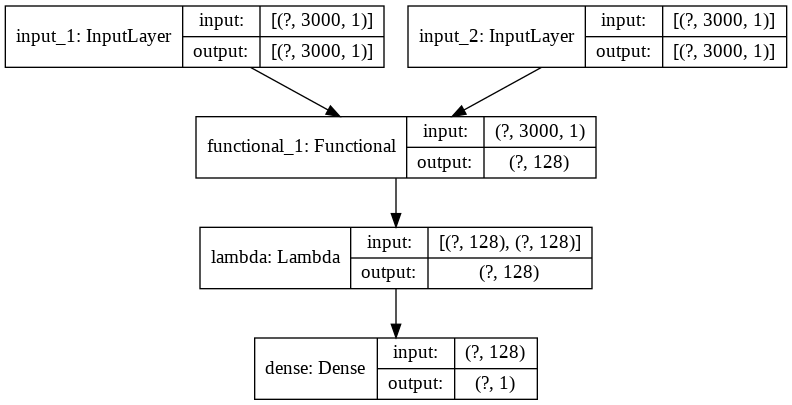

In [ ]:
plot_model(model, to_file='./model.png', show_shapes=True, show_layer_names=True)

In [ ]:
INIT_LR = 0.0005
EPOCHS = 15
BATCH_SIZE = 16
STEPS_PER_EPOCH = pair_train.shape[0] // BATCH_SIZE
VALIDATION_STEPS = pair_val.shape[0] // BATCH_SIZE
def poly_decay(epoch):
  maxEpochs = EPOCHS
  baseLR = INIT_LR
  power = 1.0

  alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
  return alpha

callbacks = [LearningRateScheduler(poly_decay)]
opt = Adam(lr=INIT_LR, amsgrad=True)

In [ ]:
def contrastive_loss(y_true, y_pred):
  margin = 1.0
  return K.mean(y_true * K.square(y_pred) + (1.0 - y_true) * K.square(K.maximum(margin - y_pred, 0.0)))

def custom_acc(y_true, y_pred):
  return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [ ]:
model.compile(loss=contrastive_loss, optimizer=opt, metrics=[custom_acc])

In [ ]:
r = model.fit(
  [pair_train[:, 0], pair_train[:, 1]], label_train[:],
  validation_data = ([pair_val[:, 0], pair_val[:, 1]], label_val[:]),
  batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks,
)

Epoch 1/15
 382/4209 [=>............................] - ETA: 1:28 - loss: 0.3334 - custom_acc: 0.5540

KeyboardInterrupt: ignored

In [ ]:
model.evaluate([pair_test[:, 0], pair_test[:, 1]], label_test[:], batch_size=BATCH_SIZE)

699/699 [==============================] - 4s 6ms/step - loss: 0.0905 - custom_acc: 0.9039


[0.09047746658325195, 0.9038805365562439]

In [ ]:
model.save('sleep_siamese_wavenet.h5')

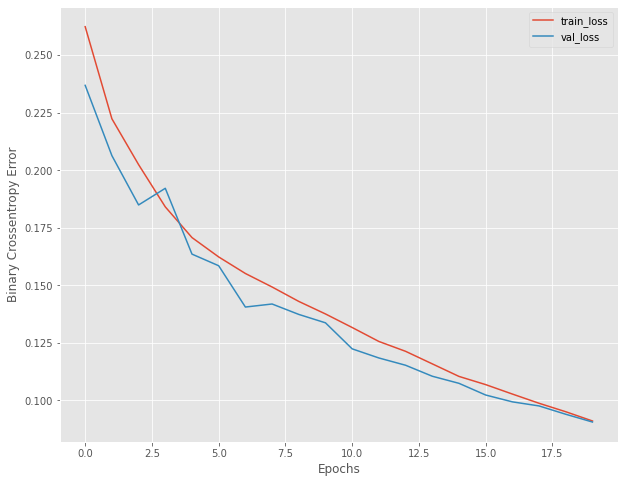

In [ ]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(r.history['loss'], label='train_loss')
plt.plot(r.history['val_loss'], label='val_loss')

plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy Error')
plt.legend(loc='best')

plt.savefig('./loss.png')
plt.show()

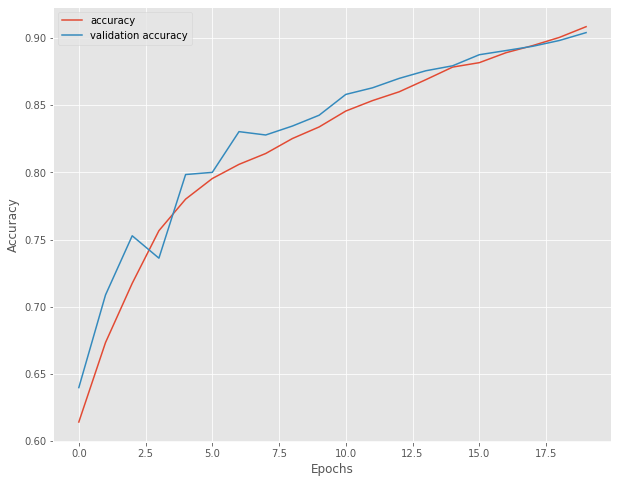

In [ ]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(r.history['custom_acc'], label='accuracy')
plt.plot(r.history['val_custom_acc'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.savefig('./acc.png')
plt.show()

In [ ]:
preds = model.predict([pair_val[:,0], pair_val[:,1]])
preds = np.reshape(preds, (preds.shape[0],))
preds = 1.0 - np.round(preds, 0)

In [ ]:
def display_images(no_of_images, image_set, preds, labels):
  if no_of_images > image_set.shape[0]:
    raise ValueError("can only enter no_of_images <= {}".format(image_set.shape[0]))

  preds_index = np.random.randint(0, image_set.shape[0], no_of_images)

  fig = plt.figure(figsize=[20, 15])

  for i,v in enumerate(preds_index):
    p1 = np.squeeze(pair_val[v, 0])
    p2 = np.squeeze(pair_val[v, 1])

    fig.add_subplot(no_of_images,1,i+1)
    plt.plot(p1)
    plt.plot(p2)

    actual_label = "similar" if labels[v] == 1.0 else "dissimilar"
    predicted_label = "similar" if preds[v] == 1.0 else "dissimilar"
    plt.title("actual: {}  predicted: {}". format(actual_label, predicted_label))

  plt.tight_layout()
  plt.show()

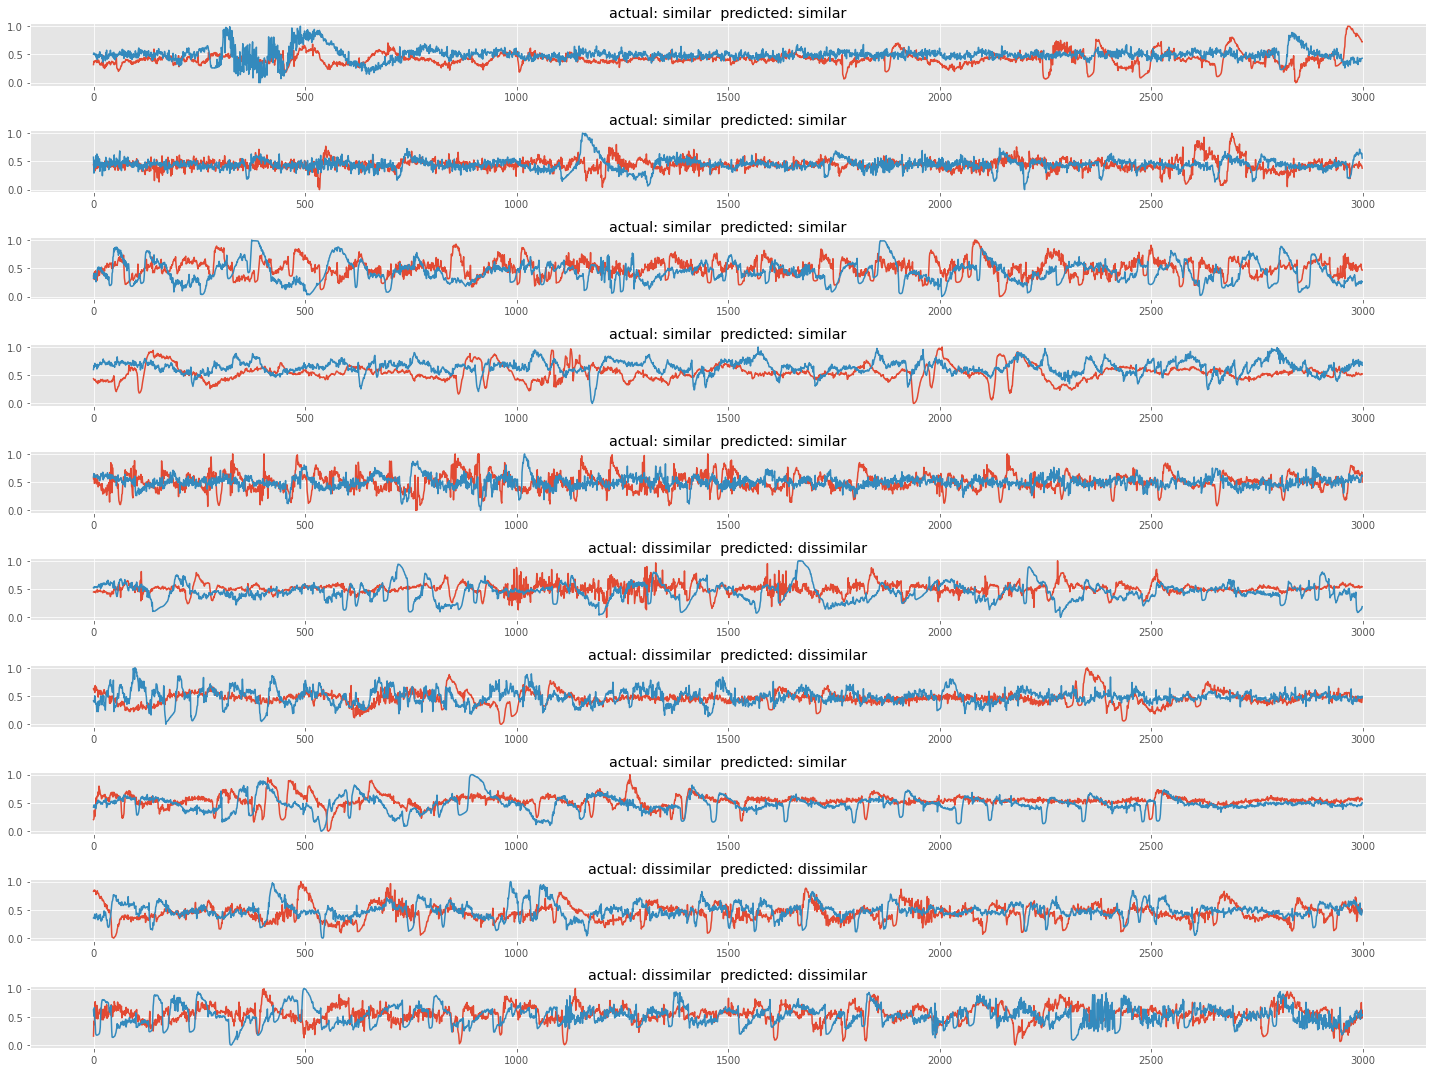

In [ ]:
display_images(10, pair_val, preds, label_val)